In [108]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [109]:
def cartoonify_image(image_path):
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply median blur for noise reduction
    gray_blur = cv2.medianBlur(gray, 7)
    
    # Apply Laplacian filter for edge detection
    edges = cv2.Laplacian(gray_blur, cv2.CV_8U, ksize=5)
    edges_thresh = cv2.threshold(edges, 30, 255, cv2.THRESH_BINARY)[1]
    img_small = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2))
    for _ in range(30):
        img_small = cv2.bilateralFilter(img_small, 9, 100, 300)
    color = cv2.resize(img_small, (img.shape[1], img.shape[0]))
    
    
    # Combine edges with the color image
    edges_inv = cv2.bitwise_not(edges_thresh)
    #cartoon = cv2.addWeighted(color, 0.8, cv2.cvtColor(edges_inv, cv2.COLOR_GRAY2RGB), 0.2, 0)
    cartoon = cv2.bitwise_and(color, color, mask=edges_inv)
    
    # Show results
    plt.figure(figsize=(20, 10)),plt.subplot(2, 3, 1),plt.imshow(img),plt.title("Original Image"),plt.axis("off")

    plt.subplot(2, 3, 2),plt.imshow(gray, cmap="gray"),plt.title("Grayscale Image"),plt.axis("off")

    plt.subplot(2, 3, 3),plt.imshow(gray_blur, cmap="gray"),plt.title("After Median Blur"),plt.axis("off")

    plt.subplot(2, 3, 4),plt.imshow(edges, cmap="gray"),plt.title("Edge Detection (Laplacian)"),plt.axis("off")

    plt.subplot(2, 3, 5),plt.imshow(edges_inv, cmap="gray"),plt.title("Edge Detection (Thresholded)"),plt.axis("off")

    plt.subplot(2, 3, 6),plt.imshow(cartoon),plt.title("Cartoon Effect"),plt.axis("off")

    plt.show()

In [110]:
def detect_lanes(image_path):
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)
    
    # Define Region of Interest (ROI)
    height, width = edges.shape
    mask = np.zeros_like(edges)
    polygon = np.array([[(50, height), (width-50, height), (width//2, height//2)]], np.int32)
    cv2.fillPoly(mask, polygon, 255)
    roi_edges = cv2.bitwise_and(edges, mask)
    
    # Detect lanes using Hough Transform
    lines = cv2.HoughLinesP(roi_edges, 1, np.pi/180, 50, minLineLength=100, maxLineGap=50)
    result = img.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(result, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
    # Show results
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1), plt.imshow(img), plt.title("Original Image"), plt.axis("off")
    plt.subplot(1,3,2), plt.imshow(edges, cmap='gray'), plt.title("Edge Detection"), plt.axis("off")
    plt.subplot(1,3,3), plt.imshow(result), plt.title("Lane Detection"), plt.axis("off")
    plt.show()

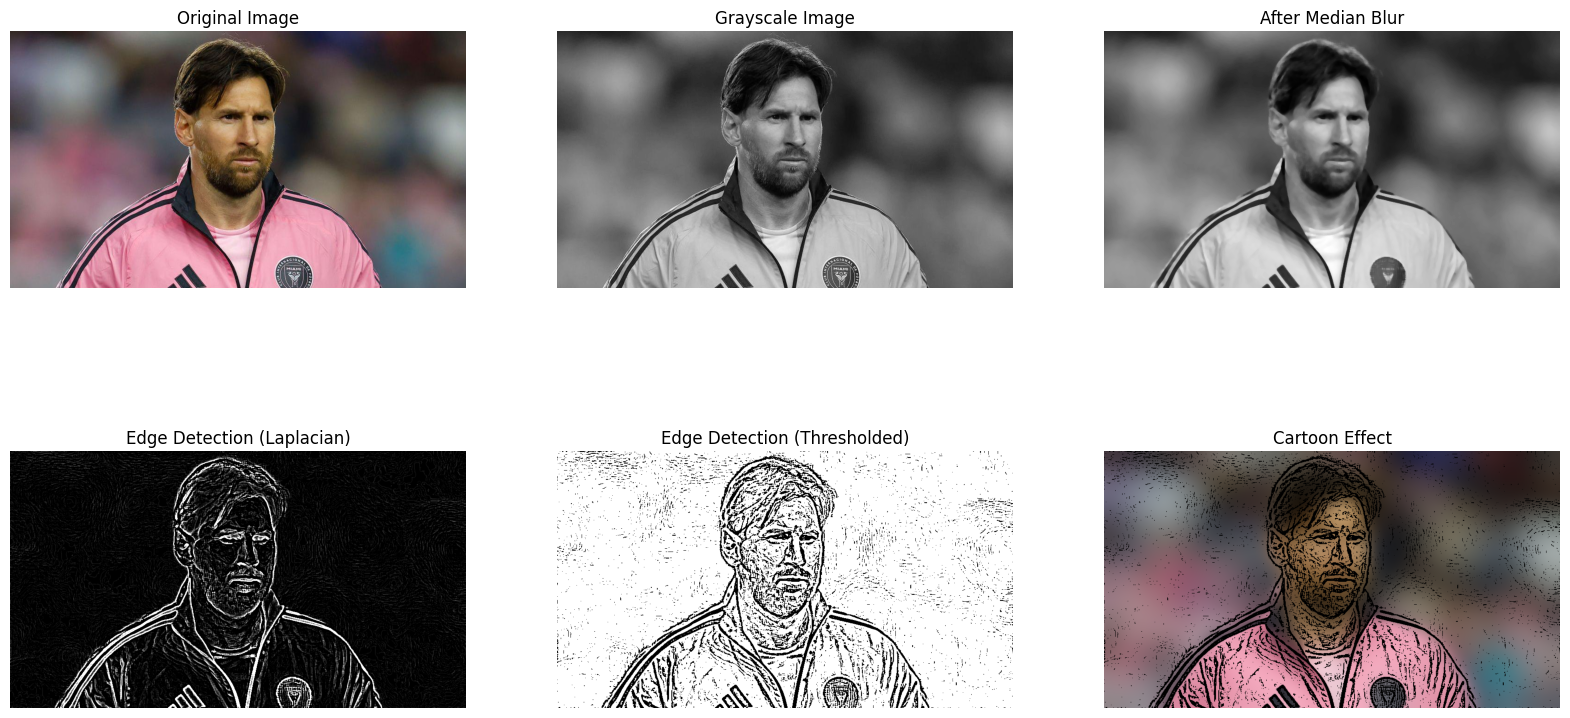

In [111]:
cartoonify_image("test images/Goat.jpg")
# detect_lanes("test2.png")

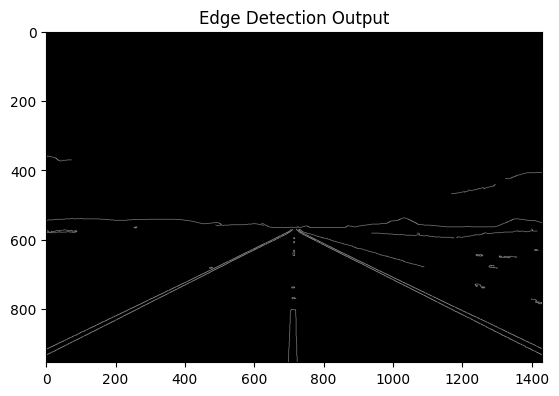

Total detected lines: 3
Line: [-57, 954, 713, 572]
Line: [1515, 954, 732, 572]


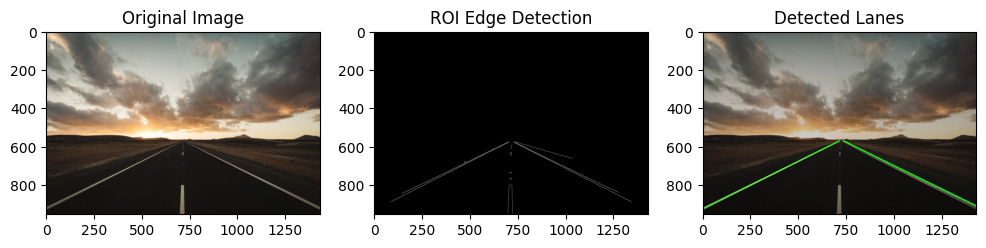

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)  
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)

    high_thresh, thresh_im = cv2.threshold(equalized, 0, 255, cv2.THRESH_OTSU)
    low_thresh = max(50, high_thresh * 0.5)

    #edges = cv2.Canny(blurred, low_thresh, high_thresh)
    edges = cv2.Canny(blurred, 30, 150)  # Lower thresholds for more edge sensitivity


    # Debugging step: Display edge-detected image
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection Output')
    plt.show()

    return edges



def region_of_interest(image):
    height, width = image.shape
    mask = np.zeros_like(image)

    # Adjusted trapezoidal ROI that removes the sky
    polygon = np.array([
        [(0, height), (width // 2 - 200, height // 2 + 100), 
         (width // 2 + 200, height // 2 + 100), (width, height)]
    ], dtype=np.int32)

    cv2.fillPoly(mask, polygon, 255)
    return cv2.bitwise_and(image, mask)


def filter_lines(lines, width):
    left_lines, right_lines, middle_lines = [], [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1 + 1e-6)

        if 0.2 < abs(slope) < 2:  # Make slope range wider
            if slope < 0 and x1 < width * 0.6:  # Increase left lane area
                left_lines.append(line)
            elif slope > 0 and x1 > width * 0.4:  # Increase right lane area
                right_lines.append(line)
            elif -0.1 < slope < 0.1 and width * 0.3 < x1 < width * 0.7:  # Middle lane
                middle_lines.append(line)

    return left_lines, right_lines, middle_lines




def average_lines(image, lines, is_middle=False):
    if not lines:
        return None

    x_coords, y_coords = [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        x_coords += [x1, x2]
        y_coords += [y1, y2]

    if is_middle:
        # Middle lane should be a nearly vertical line at the average x position
        x_avg = int(np.mean(x_coords))
        y1, y2 = image.shape[0], int(image.shape[0] * 0.6)
        return [[x_avg, y1, x_avg, y2]]
    
    # Normal lane detection (left & right lanes)
    poly = np.polyfit(x_coords, y_coords, 1)
    y1, y2 = image.shape[0], int(image.shape[0] * 0.6)
    x1, x2 = int((y1 - poly[1]) / poly[0]), int((y2 - poly[1]) / poly[0])
    return [[x1, y1, x2, y2]]


def detect_lanes(image):
    edges = preprocess_image(image)
    roi_edges = region_of_interest(edges)
    lines = cv2.HoughLinesP(roi_edges, 1, np.pi/180, 20, minLineLength=15, maxLineGap=250)

    
    if lines is None:
        return None, roi_edges
    
    left_lines, right_lines, middle_lines = filter_lines(lines, image.shape[1])
    left_avg = average_lines(image, left_lines)
    right_avg = average_lines(image, right_lines)
    middle_avg = average_lines(image, middle_lines, is_middle=True)  # FIXED
    
    return [left_avg, right_avg, middle_avg], roi_edges



def draw_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines:
        for line in lines:
            if line is not None:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)
    return cv2.addWeighted(image, 0.8, line_image, 1, 0)

# Load and process the image
image = cv2.imread('test3.png')
lines, roi_edges = detect_lanes(image)
detected_image = draw_lines(image, lines)

if lines is None:
    print("No lines detected!")
else:
    print(f"Total detected lines: {len(lines)}")
    for line in lines:
        if line is not None:
            print(f"Line: {line[0]}")



# Show results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(roi_edges, cmap='gray')
plt.title('ROI Edge Detection')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Lanes')

plt.show()


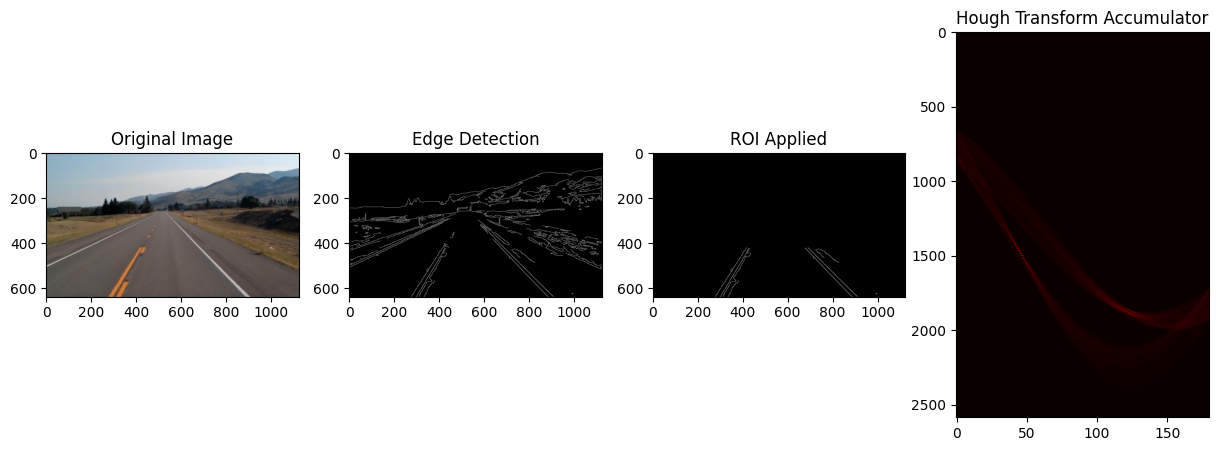

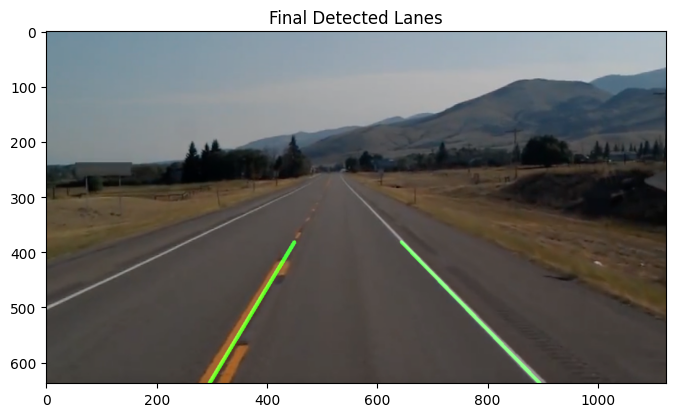

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    """Convert to grayscale, equalize histogram, apply Gaussian blur, and detect edges."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)  # Enhances contrast
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)  # Edge detection

    return edges

def region_of_interest(image):
    """Apply a mask to focus on the road lanes."""
    height, width = image.shape
    mask = np.zeros_like(image)

    polygon = np.array([
        [(0, height), (width // 2 - 200, height // 2 + 100), 
         (width // 2 + 200, height // 2 + 100), (width, height)]
    ], dtype=np.int32)

    cv2.fillPoly(mask, polygon, 255)
    return cv2.bitwise_and(image, mask)

def manual_hough_transform(edges, theta_res=1, rho_res=1, threshold=150):
    """Manual Hough Transform: Accumulator voting for lines."""
    height, width = edges.shape
    diag_len = int(np.sqrt(height**2 + width**2))  # Max rho value
    rhos = np.arange(-diag_len, diag_len, rho_res)
    thetas = np.deg2rad(np.arange(-90, 90, theta_res))  # -90 to 90 degrees

    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.int32)
    edge_points = np.argwhere(edges)  # Get edge coordinates (y, x)

    for y, x in edge_points:
        for theta_idx, theta in enumerate(thetas):
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            rho_idx = np.where(rhos == rho)[0]
            if rho_idx.size > 0:
                accumulator[rho_idx[0], theta_idx] += 1

    # Extract lines exceeding threshold
    line_indices = np.argwhere(accumulator > threshold)
    lines = []
    for rho_idx, theta_idx in line_indices:
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
        x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
        lines.append([(x1, y1, x2, y2)])

    return lines, accumulator

def filter_lines(lines, width):
    """Filter out unwanted lines based on slope."""
    left_lines, right_lines = [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1 + 1e-6)

        if 0.4 < abs(slope) < 2:  # Remove nearly horizontal/vertical lines
            if slope < 0 and x1 < width * 0.6:  # Left lane condition
                left_lines.append(line)
            elif slope > 0 and x1 > width * 0.4:  # Right lane condition
                right_lines.append(line)

    return left_lines, right_lines

def average_lines(image, lines):
    """Smooth lane lines using weighted averaging."""
    if not lines:
        return None

    x_coords, y_coords = [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        x_coords += [x1, x2]
        y_coords += [y1, y2]

    poly = np.polyfit(x_coords, y_coords, 1)  # Linear fit
    y1, y2 = image.shape[0], int(image.shape[0] * 0.6)
    x1, x2 = int((y1 - poly[1]) / poly[0]), int((y2 - poly[1]) / poly[0])
    return [[x1, y1, x2, y2]]

def draw_lines(image, lines):
    """Draw detected lane lines on the image."""
    line_image = np.zeros_like(image)
    if lines:
        for line in lines:
            if line is not None:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)
    return cv2.addWeighted(image, 0.8, line_image, 1, 0)

# Load image and run processing pipeline
image = cv2.imread('test4.png')
edges = preprocess_image(image)
roi_edges = region_of_interest(edges)
lines, accumulator = manual_hough_transform(roi_edges)

# Filter and average detected lines
left_lines, right_lines = filter_lines(lines, image.shape[1])
left_avg = average_lines(image, left_lines)
right_avg = average_lines(image, right_lines)

# Draw detected lanes
detected_image = draw_lines(image, [left_avg, right_avg])

# Show results
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

# Edge Detection
plt.subplot(1, 4, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')

# ROI Applied
plt.subplot(1, 4, 3)
plt.imshow(roi_edges, cmap='gray')
plt.title('ROI Applied')

# Accumulator array
plt.subplot(1, 4, 4)
plt.imshow(accumulator, cmap='hot', aspect='auto')
plt.title('Hough Transform Accumulator')

plt.show()

# Show Final Lane Detection
plt.figure(figsize=(8, 5))
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
plt.title('Final Detected Lanes')
plt.show()
